In [1]:
# !jupyter nbconvert --to script grad_cam.ipynb

[NbConvertApp] Converting notebook grad_cam.ipynb to script
[NbConvertApp] Writing 2846 bytes to grad_cam.py


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

import grad_cam
from meanpertrub import MeanPertrub
os.chdir('../')
from model3d import mri_model
from model3d.mri_model import train, get_accuracy, get_prediction

device = torch.device('cuda:1' if torch.cuda.is_available() else'cpu')
torch.manual_seed(1)
np.random.seed(1)
CHECKPOINTS_DIR = './checkpoints/'

In [2]:
X, y = np.load('/workspace/InterpretableNeuroDL/data/tensors.npy'), np.load('/workspace/InterpretableNeuroDL/data/labels.npy')#change path 
X = X[:, None,:,:,:]
print(X.shape, y.shape)
dataset = mri_model.MriData(X, y)
C = 32

(1113, 1, 58, 70, 58) (1113,)


## Meaningful Perturbations

In [3]:
loader = torch_data.DataLoader(dataset, batch_size=30, shuffle=False)
net = mri_model.MriNet(C).to(device)
net.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_model_all'), map_location=device))#change path
net = net.float()
net.eval()
for param in net.parameters():
    param.requires_grad = False
pred = np.concatenate(get_prediction(net, loader, device), axis=0)
pertrub = MeanPertrub(device)

In [4]:
start = time.time()
masks_pertrub = pertrub.get_masks(X, pred, net)
print(time.time() - start)
np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub'), masks_pertrub)

1it [00:57, 57.52s/it]

0 iteration is finished.


26it [23:00, 51.59s/it]

25 iteration is finished.


51it [44:23, 54.55s/it]

50 iteration is finished.


76it [1:18:15, 92.18s/it]

75 iteration is finished.


101it [1:49:43, 53.07s/it]

100 iteration is finished.


105it [1:53:14, 64.71s/it]


KeyboardInterrupt: 

In [14]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-97GpyViivxDUUL3_7tgSKBGpYopw9vA' -O './checkpoints/masks_pertrub'


--2020-09-29 16:20:36--  https://docs.google.com/uc?export=download&id=1-97GpyViivxDUUL3_7tgSKBGpYopw9vA
Resolving docs.google.com (docs.google.com)... 209.85.233.194, 2a00:1450:4010:c03::c2
Connecting to docs.google.com (docs.google.com)|209.85.233.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./checkpoints/masks_pertrub’

./checkpoints/masks     [ <=>                ]   3.17K  --.-KB/s    in 0s      

2020-09-29 16:20:41 (24.5 MB/s) - ‘./checkpoints/masks_pertrub’ saved [3249]



In [16]:
masks_pertrub = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_pertrub'), allow_pickle=True)# or X_masks


OSError: Failed to interpret file './checkpoints/masks_pertrub' as a pickle

In [ ]:
man_idx = np.arange(y.shape[0])[y == 1]
woman_idx = np.arange(y.shape[0])[y == 0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = man_mean_mask + woman_mean_mask

In [7]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
EPOCHS = 20
c = 32
cross_vall_acc_list = []
j = 0
for train_index, test_index in skf.split(X, y,):
  print('Doing {} split'.format(j))
  j += 1

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  train_dataset = MriData(X_train, y_train)
  val_dataset = MriData(X_test*Mask, y_test)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=28, shuffle=False) 
  
  model = MriNet(c).to(device)
  criterion = nn.NLLLoss( ).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

  train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False, verbose=False) 
  cross_vall_acc_list.append(get_accuracy(model, val_loader))
cross_mask.append(cross_vall_acc_list)
cv_acc_binary = np.array(cross_mask)

In [19]:
print('Average cross-validation accuracy (10-folds):', sum(cross_vall_acc_list)/len(cross_vall_acc_list))

0.9299191374663073

In [9]:
women = []
men = []
for i,img in enumerate(X):
    if y[i] == 0:
        women.append(np.count_nonzero(X[i])/np.count_nonzero(X[i]*tensors_mask[i]))
    else:
        men.append(np.count_nonzero(X[i])/np.count_nonzero(X[i]*tensors_mask[i]))
print('For men number of non zero voxel in new tensor {:.2} times less on average'.format(np.mean(men)))
print('For women number of non zero voxel in new tensor {:.2} times less on average'.format(np.mean(women)))

For men number of non zero voxel in new tensor 9.1 times less on average
For women number of non zero voxel in new tensor 3.5 times less on average


## Grad CAM

In [8]:
model = grad_cam.MriNetGrad(C).to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_model_all_grad'), map_location=device))#change path
model.eval()
pass

In [5]:
loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
masks_grad = grad_cam.get_masks(model, loader, device, mask_type='grad_cam')
np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam'), masks_grad)

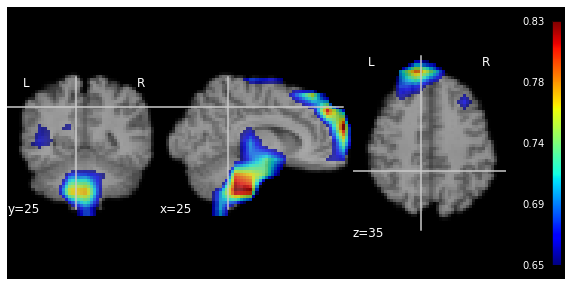

In [6]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.65)
plt.show()
fig.savefig("grad_cam.pdf", bbox_inches='tight')

## Guided Back-propagation

In [6]:
masks_gb = grad_cam.get_masks(model, loader, device, mask_type='guided_backprop')
np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb'), masks_gb)

100%|██████████| 1113/1113 [05:20<00:00,  3.47it/s]


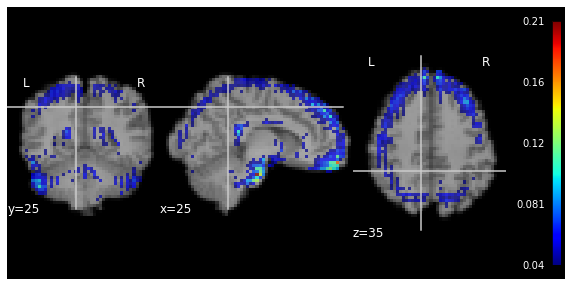

In [7]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.04)
plt.show()
# fig.savefig("guided backpropagation.pdf", bbox_inches='tight')